## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os
import time

from PIL import Image, ImageOps

import random

#import any other library you need below this line

In [5]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
   creating: data/cells/
  inflating: __MACOSX/data/._cells   
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/cells/.DS_Store    
  inflating: __MACOSX/data/cells/._.DS_Store  
   creating: data/cells/scans/
  inflating: __MACOSX/data/cells/._scans  
   creating: data/cells/labels/
  inflating: __MACOSX/data/cells/._labels  
  inflating: data/cells/scans/BMMC_16.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_16.bmp  
  inflating: data/cells/scans/BMMC_17.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_17.bmp  
  inflating: data/cells/scans/BMMC_15.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_15.bmp  
  inflating: data/cells/scans/BMMC_14.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_14.bmp  
  inflating: data/cells/scans/BMMC_28.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_28.bmp  
  inflating: data/cells/scans/BMMC_10.bmp  
  inflat

## Defining the Dataset Class

In [2]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = True, train_test_split = 0.8, augment_data = True):
    super(Cell_data, self).__init__()
    self.size = size
    self.train = train
    self.augment_data = augment_data
    self.image_files = os.path.join(data_dir, 'scans')
    self.image_files_list = os.listdir(self.image_files)
    self.label_files = os.path.join(data_dir, 'labels')
    self.label_files_list = self.image_files_list


    self.images = [os.path.join(self.image_files, img) for img in self.image_files_list]
    self.labels = [os.path.join(self.label_files, img) for img in self.image_files_list]

    split = int(len(self.images)*train_test_split)
    if train==True:
      self.data_x = self.images[:split]
      self.data_y = self.labels[:split]
    else:
      self.data_x = self.images[split:]
      self.data_y = self.labels[split:]

    # if train == True:
    #   self.data_x = random.sample(self.image_files_list, int(len(self.image_files_list)*train_test_split))
    #   self.data_y = self.data_x
    #   self.data_x = [os.path.join(self.image_files, i) for i in self.data_x]
    #   self.data_y = [os.path.join(self.label_files, i) for i in self.data_y]

    # else:
    #   train_data_x = random.sample(self.image_files_list, int(len(self.image_files_list)*train_test_split))
    #   test_data_x = [x for x in self.image_files_list if x not in train_data_x]
    #   self.data_x = [os.path.join(self.image_files, i) for i in test_data_x]
    #   self.data_y = [os.path.join(self.label_files, i) for i in test_data_x]

    self.transforms1 = transforms.Compose([
            transforms.ToTensor(),
        ])
    self.transforms2 = transforms.Compose([
            transforms.PILToTensor(),
        ])
    self.train_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0], [1]),
    #     transforms.RandomHorizontalFlip(p=0.5),
    #     transforms.RandomVerticalFlip(p=0.5),
    #     transforms.ColorJitter(brightness=[0.6, 1.4],
    #    contrast=[0.6, 1.4], saturation=[0.5, 1.5], hue=[-0.03, 0.03])
    ])
    # self.val_tf = transforms.Compose([
    #     # transforms.Normalize([0, 0, 0], [1, 1, 1]),
    #     transforms.ToTensor()])

  def __getitem__(self, idx):
    data_x = self.data_x[idx]
    data_y = self.data_y[idx]
    scan_image = Image.open(data_x).resize((self.size,self.size))
    label_image = Image.open(data_y).resize((self.size,self.size))

    #data augmentation part
    if self.train:
      if self.augment_data:
        augment_mode = np.random.randint(0, 5)
        if augment_mode == 0:
          #todo
          #flip image vertically
          augmented_scan_image = TF.vflip(scan_image)
          augmented_label_image = TF.vflip(label_image)
        elif augment_mode == 1:
          #todo
          #flip image horizontally
          augmented_scan_image = TF.hflip(scan_image)
          augmented_label_image = TF.hflip(label_image)
        elif augment_mode == 2:
          #todo
          # # zoom image

          augmented_scan_image = scan_image
          augmented_label_image = label_image
          # # zoom_size = random.randint(int(self.size*0.7), self.size)
          # # zoom_size = zoom_size // 2 * 2
          # zoom_size = 1
          # random_crop_transform = transforms.RandomCrop(zoom_size)
          # augmented_scan_image = random_crop_transform(scan_image)
          # augmented_label_image = random_crop_transform(label_image)
          # augmented_label_image= label_image
        elif augment_mode == 3:
          #todo
          #rotate image
          angle = random.randint(-35,35)
          augmented_scan_image = TF.rotate(scan_image, angle)
          augmented_label_image = TF.rotate(label_image, angle)
        elif augment_mode == 4:
          #gamma correction
          gamma = random.randrange(2,9)/10
          augmented_scan_image = TF.adjust_gamma(scan_image, gamma)
          augmented_label_image = label_image
      else:
        augmented_scan_image = scan_image
        augmented_label_image = label_image
    else:
      augmented_scan_image = scan_image
      augmented_label_image = label_image
    # return self.train_tf(augmented_scan_image), torch.ceil(self.train_tf(augmented_label_image))
          # return image and mask in tensors
    # print(augmented_scan_image.size)
    # print(augmented_label_image.size)
    img = self.transforms1(augmented_scan_image)
    label = self.transforms2(augmented_label_image)
    # print(img.size)
    # print(label.size)
    mean, std = img.mean([1, 2]), img.std([1, 2])
    self.normTrans = transforms.Compose([
        transforms.Normalize(mean, std)
    ])
    img = self.normTrans(img)
    return img,label



  def __len__(self):
    return len(self.data_x)
    # pass
    # return len(self.images)


### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [3]:
class twoConvBlock(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(twoConvBlock, self).__init__()
    #todo
    #initialize the block
    self.conv_layer1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1)
    self.conv_layer2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride =1)
    self.batch_norm_layer = nn.BatchNorm2d(output_channels)

  def forward(self,image):
    #todo
    #implement the forward path
    image = self.conv_layer1(image)
    image = F.relu(image)
    image = self.conv_layer2(image)
    image = self.batch_norm_layer(image)
    image = F.relu(image)
    return image

class downStep(nn.Module):
  def __init__(self):
    super(downStep, self).__init__()
    #todo
    #initialize the down path
    self.max_pool_layer = nn.MaxPool2d(kernel_size=2, stride = 2)

  def forward(self, image):
    #todo
    #implement the forward path
    image = self.max_pool_layer(image)
    return image


class upStep(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(upStep, self).__init__()
    #todo
    #initialize the up path
    self.up_sampling_layer = nn.ConvTranspose2d(input_channels, output_channels, kernel_size = 2, stride=2)
    self.conv = twoConvBlock(input_channels, output_channels)

  def forward(self,up, conv):
    #todo
    #implement the forward path
    upsampled = self.up_sampling_layer(up)
    crop_h = (conv.size()[2]-upsampled.size()[2])
    crop_w = (conv.size()[3]-upsampled.size()[3])
    # print(upsampled.shape)
    pad_upsampled = F.pad(upsampled, [crop_w // 2, crop_w - crop_w // 2,
                        crop_h // 2, crop_h - crop_h // 2])

    # padding = [crop_w // 2, crop_w - crop_w // 2, crop_h // 2, crop_h - crop_h // 2]

    # print(padding)

    # pad_upsampled = F.pad(upsampled, padding)

    #crop_conv = conv[:, :, crop_h_fix:conv.shape[2]-crop_h, crop_w_fix:conv.shape[3]-crop_w]
    # print(conv.shape)
    # print(pad_upsampled.shape)
    return torch.cat([conv, pad_upsampled],dim=1)

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    #todo
    #initialize the complete model
    self.conv1 = twoConvBlock(1,64)
    self.conv2 = twoConvBlock(64, 128)
    self.conv3 = twoConvBlock(128, 256)
    self.conv4 = twoConvBlock(256, 512)
    self.conv5 = twoConvBlock(512, 1024)
    self.conv6 = twoConvBlock(1024, 512)
    self.conv7 = twoConvBlock(512, 256)
    self.conv8 = twoConvBlock(256, 128)
    self.conv9 = twoConvBlock(128, 64)
    self.conv10 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1)

    self.down_step = downStep()

    self.upstep1 = upStep(1024, 512)
    self.upstep2 = upStep(512, 256)
    self.upstep3 = upStep(256, 128)
    self.upstep4 = upStep(128, 64)


  def forward(self, input):
    #todo
    #implement the forward path
    conv1_ = self.conv1(input)


    downsampled = self.down_step(conv1_)
    conv2_ = self.conv2(downsampled)
    downsampled = self.down_step(conv2_)
    conv3_ = self.conv3(downsampled)
    downsampled = self.down_step(conv3_)
    conv4_ = self.conv4(downsampled)
    downsampled = self.down_step(conv4_)
    conv5_ = self.conv5(downsampled)
    concat = self.upstep1(conv5_, conv4_)
    conv6_ = self.conv6(concat)
    concat = self.upstep2(conv6_, conv3_)
    conv7_ = self.conv7(concat)
    concat = self.upstep3(conv7_, conv2_)
    conv8_ = self.conv8(concat)
    concat = self.upstep4(conv8_, conv1_)
    conv9_ = self.conv9(concat)
    out = self.conv10(conv9_)

    return out

### Training

In [6]:
#Paramteres

#input image-mask size
image_size = 577
#root directory of project
root_dir = os.getcwd()

#use checkpoint model for training
load = False

#use GPU for training
gpu = True

data_dir = os.path.join('./data/cells')

#training batch size
batch_size = 4
trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = batch_size)

device = torch.device('cuda:0' if gpu else 'cpu')
# device = torch.device('cpu')

In [4]:
def get_acc_loss(model, dataloaderx, device):
  model.eval()
  total = 0
  correct = 0
  total_loss = 0
  # test_losses = []
  # total_steps = 0

  with torch.no_grad():
      for i, data in enumerate(dataloaderx):
          image, label = data

          image = image.to(device)
          label = label.long().to(device)

          pred = model(image)

          # print("label.shape : ", label.shape)
          # print("pred.shape : ", pred.shape)

          crop_x = (label.shape[2] - pred.shape[2]) // 2
          crop_y = (label.shape[3] - pred.shape[3]) // 2

          label = label[:, :,crop_x: label.shape[2] - crop_x, crop_y: label.shape[3] - crop_y].squeeze(1)

          loss = criterion(pred, label)
          total_loss += loss.item()

          # test_losses.append(loss.item())
          # total_steps += 1

          _, pred_labels = torch.max(pred, dim = 1)

          total += label.shape[0] * label.shape[1] * label.shape[2]
          correct += (pred_labels == label).sum().item()
  return correct / total, total_loss / dataloaderx.__len__()
  print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / dataloaderx.__len__()))

In [7]:
import sys
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

d2l = sys.modules[__name__]


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')


class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        display.clear_output(wait=True)
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        # display.display(self.fig)

    def save(self, file):
        self.fig.savefig(file)



In [ ]:
#learning rate
lr = 1e-4

#number of training epochs
epoch_n = 20

animator_loss = Animator(xlabel='epoch',
            ylabel='loss',
            legend=['train_loss', 'test_loss'],
            xlim=[1, epoch_n], figsize=(14, 10))

animator_acc = Animator(xlabel='epoch',
            ylabel='acc',
            legend=['train_acc', 'test_acc'],
            xlim=[1, epoch_n], figsize=(14, 10))

model = UNet()
model = model.to(device)




if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

train_losses = []
test_losses = []
total_steps = 0
model.train()
start = time.time()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()

  for i, data in enumerate(trainloader):
    # print("data : ", data)
    image, label = data
#     print("image : ", image.shape)
#     print("label : ", label.shape)

    image = image.to(device)
    label = label.long().to(device)
    # print("image.shape : ", image.shape)


    pred = model(image)

    crop_x = (label.shape[2] - pred.shape[2]) // 2
    crop_y = (label.shape[3] - pred.shape[3]) // 2


    label = label[:, :, crop_x: label.shape[2] - crop_x, crop_y: label.shape[3] - crop_y].squeeze(1)
#     print("pred.shape : ", pred.shape)
#     print("label.shape ; ", label.shape)

    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
    # train_losses.append(loss.item())
    total_steps += 1

    if i> 0 and i % 10 == 0:
      print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  print('Epoch %d / %d ' % (e + 1, epoch_n))

  train_acc, train_loss = get_acc_loss(model, trainloader, device)
  test_acc, test_loss = get_acc_loss(model, testloader, device)
  print("train_acc : ", train_acc)
  print("train_loss : ", train_loss)
  print("test_acc : ", test_acc)
  print("test_loss : ", test_loss)

  animator_loss.add(e + 1, (train_loss, test_loss))
  animator_acc.add(e + 1, (train_acc, test_acc))

save_p_path = os.getcwd()

animator_loss.save(os.path.join(save_p_path, 'loss.png'))
animator_acc.save(os.path.join(save_p_path, 'accuracy.png'))

torch.save(model.state_dict(), 'checkpoint.pt')




end = time.time()
cost = end - start
print(f"Cost: {cost:.2f} s")

Epoch 10 / 20 
train_acc :  0.8848403606363954
train_loss :  0.4319827761501074
test_acc :  0.8602642072392908
test_loss :  0.5976158082485199


### Testing and Visualization

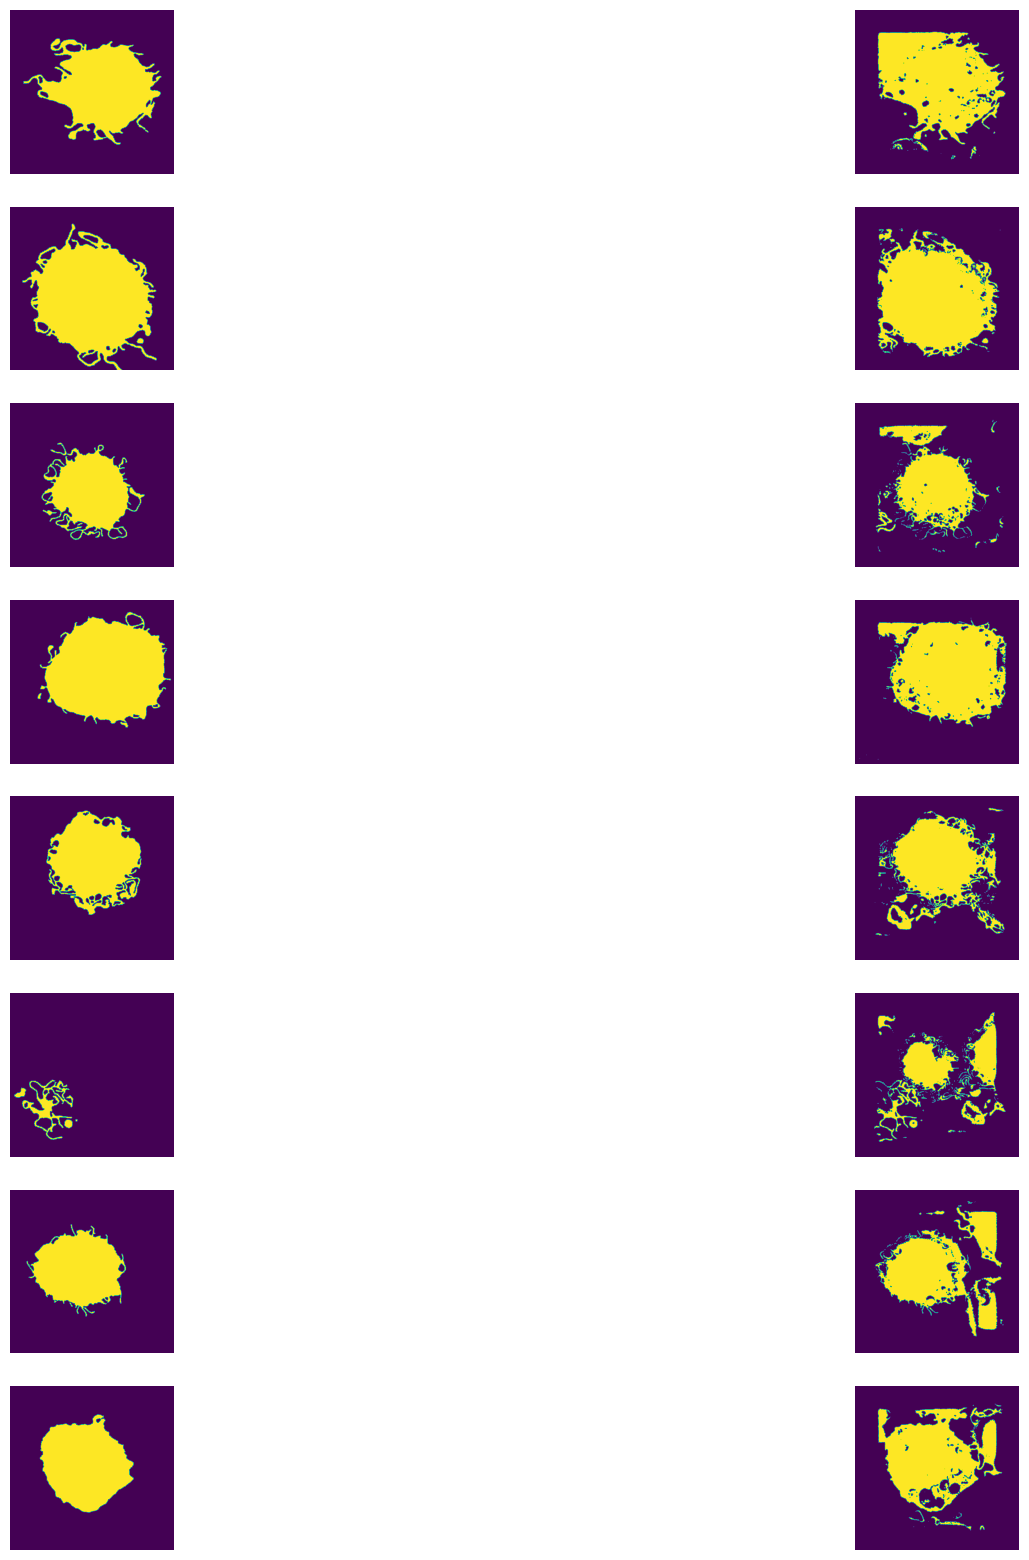

In [ ]:
model.eval()


output_masks = []
output_labels = []

with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)

    input_image = image.unsqueeze(0).to(device)
    pred = model(input_image)

    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()

    crop_x = (labels.shape[1] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[2] - output_mask.shape[1]) // 2
    labels = labels[:,crop_x: labels.shape[1] - crop_x, crop_y: labels.shape[2] - crop_y].squeeze(0).numpy()
    output_masks.append(output_mask)
    output_labels.append(labels)

fig, axes = plt.subplots(testset.__len__(), 2, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')